In [1]:
from read_data import read_enhanced_microscore_dataset
from plots import first_plot, second_plot, third_plot, forth_plot, plot_performance, fith_plot
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
df = read_enhanced_microscore_dataset()
df.shape

(68228, 43)

In [3]:
df_base = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "Metros",
    # "CodigoPostal", # Eliminado
    "Latitud",
    "Longitud",
    'Caracteristicas'
]]

In [4]:
df_microscore = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "Metros",
    # "CodigoPostal", # Eliminado
    "Latitud",
    "Longitud",
    "RentaBrutaHogar",
    "RentaBrutaPersona",
    "poblacion_2023",
    "%_servicios",
    "densidad_inm_m2",
    "%_agricultura",
    "%_industria",
    "%_construccion",
    'Caracteristicas',
    'University_Distance',
    'School_Distance', 'Kindergarten_Distance', 'City Center_Distance',
       'Supermarket_Distance', 'Bakery_Distance', 'Hospital_Distance',
       'Pharmacy_Distance', 'Restaurant_Distance', 'Café_Distance',
       'Park_Distance', 'Gym_Distance', 'Movie Theater_Distance',
       'Theater_Distance', 'Shopping Mall_Distance', 'Bus Stop_Distance',
       'Metro Station_Distance', 'Score'
]]

In [5]:
def prepare_data(df):
    categorical_cols = ['Caracteristicas']
    df = pd.get_dummies(df, columns=categorical_cols)
    df = df.fillna(-1)
    return df

In [6]:
df_base = prepare_data(df_base)
df_microscore = prepare_data(df_microscore)

In [7]:
df_base.shape

(68228, 12)

In [8]:
df_microscore.shape

(68228, 38)

In [9]:
def train_test_model(model, df_numeric, epochs):
    X = df_numeric.drop(columns=['Precio'])
    y = df_numeric['Precio']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=56
    )

    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)

    early_stopping = EarlyStopping(
            monitor='val_loss',   
            patience=5,           
            min_delta=1e-4,       
            restore_best_weights=True  
        )
    
    # Entrenamiento del modelo
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluacion con test set
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss (MSE): {test_loss}')
    
    # Prediccion test set
    y_pred = model.predict(X_test)
    
    # Comparacion
    comparison_df = pd.DataFrame({
        'Precio actual': y_test.flatten(),
        'Prediccion': y_pred.flatten()
    })
    
    print("\nComparacion precio actual y prediccion")
    print(comparison_df.head(10))

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    
    print("\n--- Metricas Cross-Validation ---")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")

    return y_test, y_pred

    # return y_test.flatten(), y_pred.flatten()

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def train_test_model_kfold_with_early_stopping(model, df_numeric, epochs):
    X = df_numeric.drop(columns=['Precio'])
    y = df_numeric['Precio'].values.reshape(-1, 1)

    # Inicializar KFold con 5 splits
    kf = KFold(n_splits=5, shuffle=True, random_state=56)
    
    mae_list = []
    rmse_list = []
    mape_list = []
    
    fold = 1
    
    for train_index, test_index in kf.split(X):
        print(f"\n--- Fold {fold} ---")
        fold += 1
        
        # Separar datos
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Escalado de los datos
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Early stopping 
        early_stopping = EarlyStopping(
            monitor='val_loss',   
            patience=5,           
            min_delta=1e-4,       
            restore_best_weights=True  
        )

        # Entrenamiento modelo
        history = model.fit(
            X_train_scaled,
            y_train,
            epochs=epochs,
            batch_size=32,
            validation_data=(X_test_scaled, y_test),
            verbose=0,  
            callbacks=[early_stopping]  
        )

        # Prediccion
        y_pred = model.predict(X_test_scaled)

        # Calculo metricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)

        mae_list.append(mae)
        rmse_list.append(rmse)
        mape_list.append(mape)

        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    
    print("\n--- Metricas Cross-Validation ---")
    print(f"Average MAE: {np.mean(mae_list):.2f}")
    print(f"Average RMSE: {np.mean(rmse_list):.2f}")
    print(f"Average MAPE: {np.mean(mape_list):.2%}")

    return y_test.flatten(), y_pred.flatten()

In [11]:
loss_function='mean_absolute_error'

In [12]:
#Kfold con datos originales 
df_used = df_base

model = Sequential([
    Dense(512, input_dim=df_used.drop(columns=['Precio']).shape[1], activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss=loss_function)

y_test_base, y_pred_base = train_test_model_kfold_with_early_stopping(model, df_used, 30)

C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Fold 1 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 66338.10, RMSE: 156976.01, MAPE: 30.15%

--- Fold 2 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 64625.87, RMSE: 150792.43, MAPE: 27.89%

--- Fold 3 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 66290.21, RMSE: 163922.85, MAPE: 29.16%

--- Fold 4 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 64073.24, RMSE: 145954.41, MAPE: 27.94%

--- Fold 5 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 63849.42, RMSE: 148581.19, MAPE: 28.05%

--- Cross-Validation Metrics ---
Average MAE: 65035.37
Average RMSE: 153245.38
Average MAPE: 28.64%


In [13]:
#Kfold con datos enriquecidos 
df_used = df_microscore

model = Sequential([
    Dense(512, input_dim=df_used.drop(columns=['Precio']).shape[1], activation='relu', name='Input_Layer'),
    Dense(256, activation='relu', name='Hidden_Layer_1'),
    Dense(128, activation='relu', name='Hidden_Layer_2'),
    Dense(64, activation='relu', name='Hidden_Layer_3'),
    Dense(32, activation='relu', name='Hidden_Layer_4'),
    Dense(16, activation='relu', name='Hidden_Layer_5'),
    Dense(1, activation='linear', name='Output_Layer')
])
model.compile(optimizer='adam', loss=loss_function)

y_test_micro, y_pred_micro = train_test_model_kfold_with_early_stopping(model, df_used, 30)


--- Fold 1 ---


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 58715.68, RMSE: 138562.83, MAPE: 24.96%

--- Fold 2 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 55587.92, RMSE: 134672.39, MAPE: 24.24%

--- Fold 3 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 53497.35, RMSE: 141181.22, MAPE: 22.79%

--- Fold 4 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 50480.73, RMSE: 121765.91, MAPE: 21.41%

--- Fold 5 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 51241.02, RMSE: 125970.03, MAPE: 21.94%

--- Cross-Validation Metrics ---
Average MAE: 53904.54
Average RMSE: 132430.48
Average MAPE: 23.07%


In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Layer (Dense)                  │ (None, 512)                 │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_1 (Dense)               │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_2 (Dense)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_3 (Dense)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_4 (Dense)               │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_5 (Dense)               │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 583,685 (2.23 MB)

 Trainable params: 194,561 (760.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 389,124 (1.48 MB)

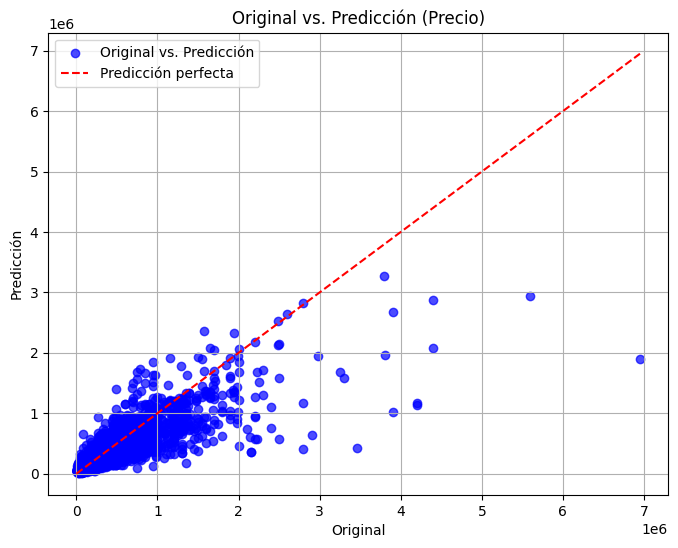

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


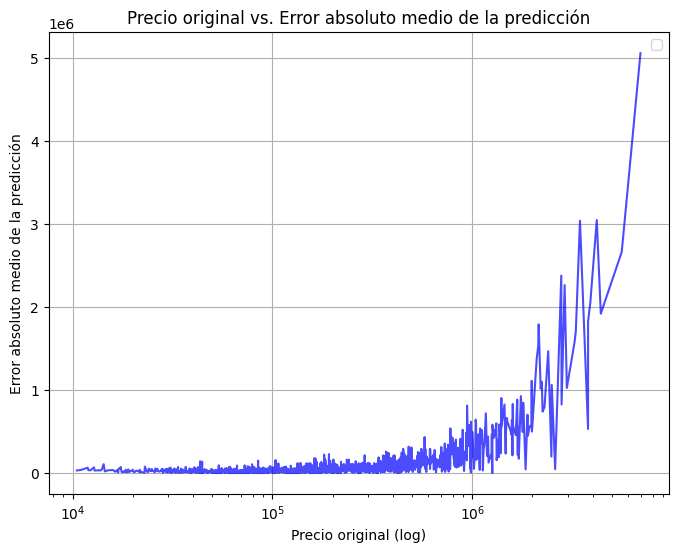

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


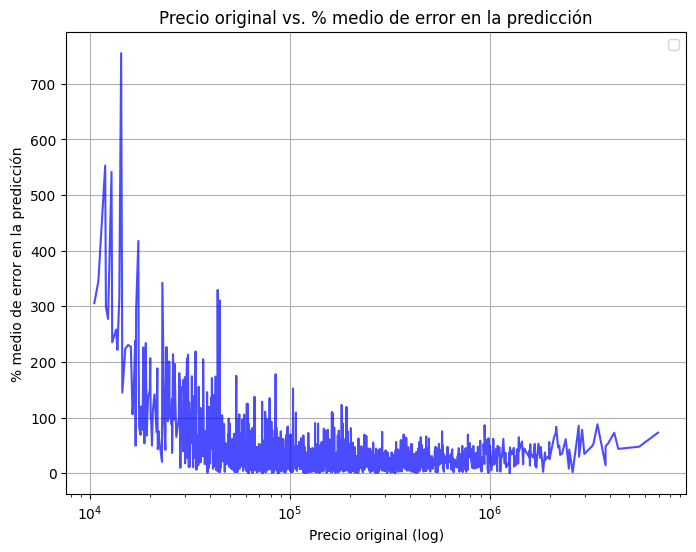

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_plot.groupby("log_bin")["%error"].mean().reset_index()


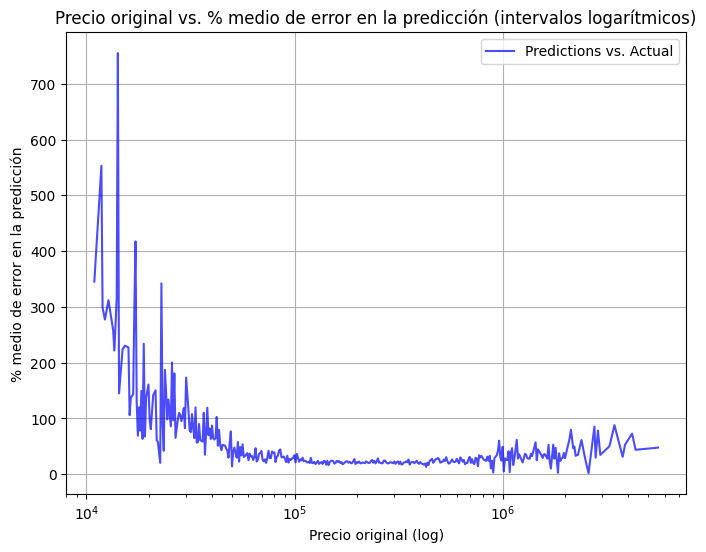

In [15]:
plot_performance(y_test_base, y_pred_base)

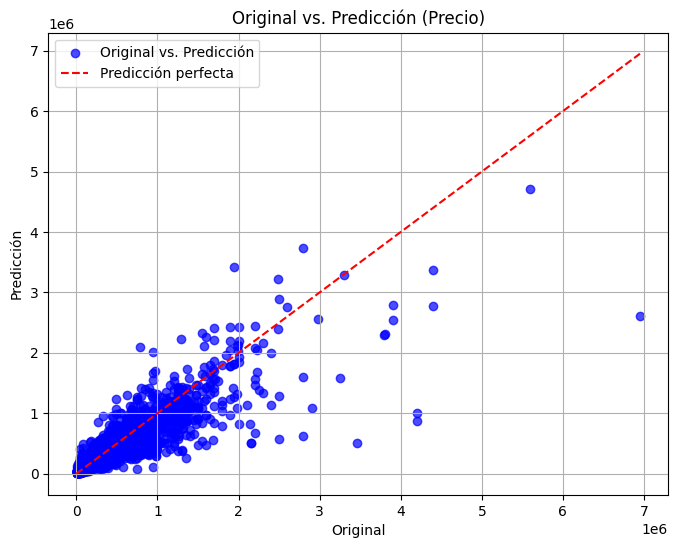

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


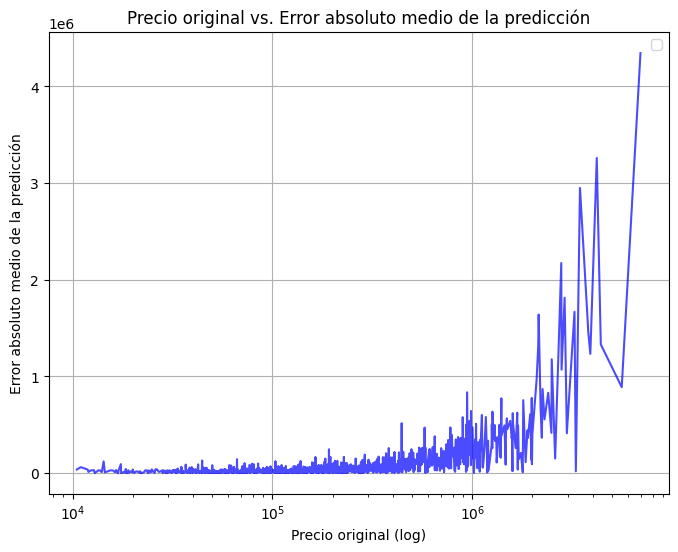

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


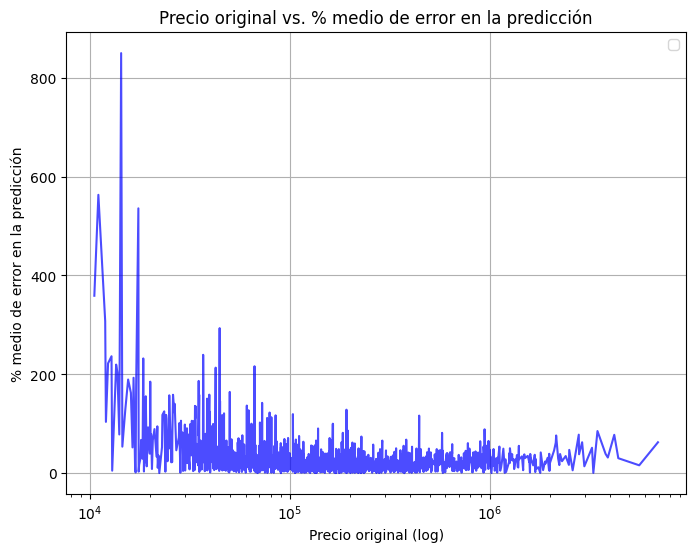

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_plot.groupby("log_bin")["%error"].mean().reset_index()


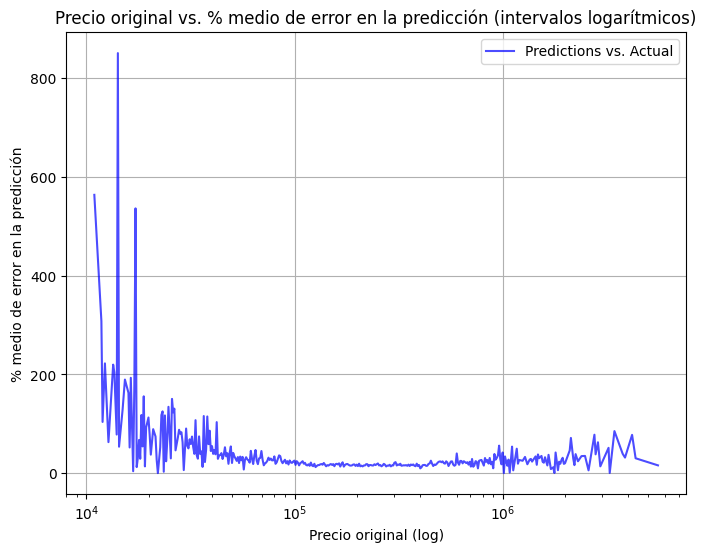

In [16]:
plot_performance(y_test_micro, y_pred_micro)

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_blue = df_plot_base.groupby("log_bin")["%error"].mean().reset_index()
C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_red = df_plot__micro.groupby("log_bin")["%error"].mean().reset_index()


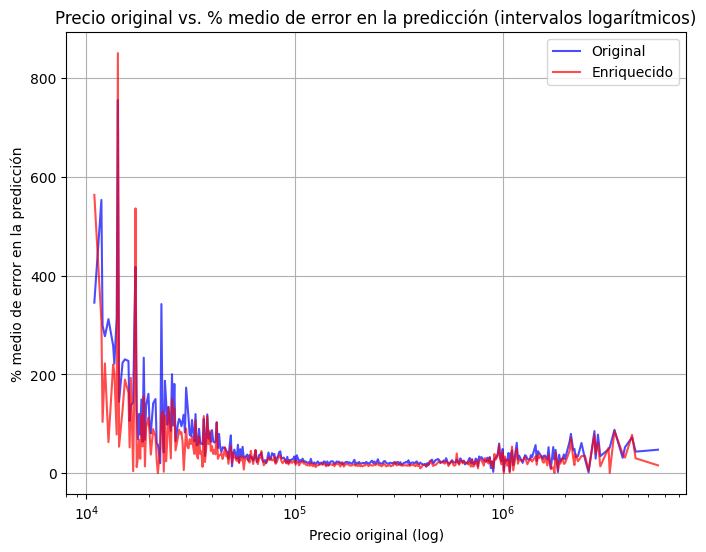

In [17]:
fith_plot(y_test_base, y_pred_base, y_test_micro, y_pred_micro)

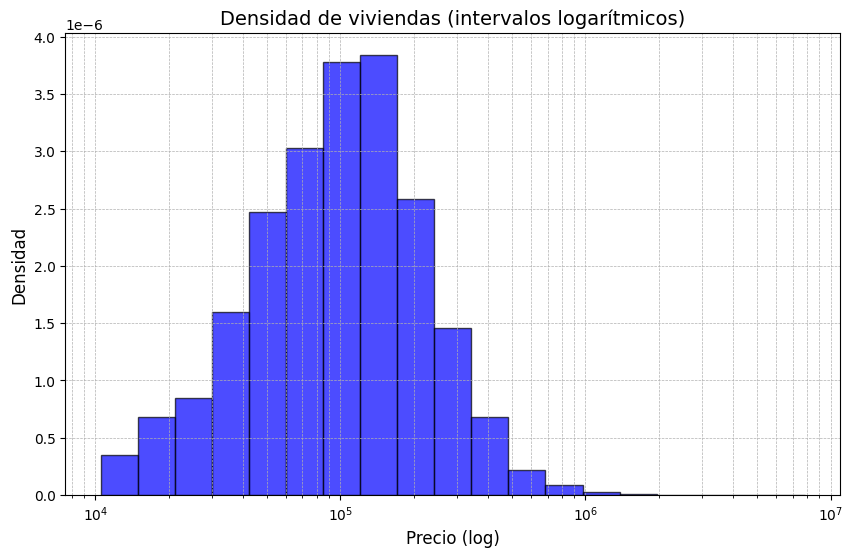

In [18]:
df_used = df_microscore

min_price = df_used['Precio'].min()
max_price = df_used['Precio'].max()
bins = np.logspace(np.log10(min_price), np.log10(max_price), num=20)  

plt.figure(figsize=(10, 6))
plt.hist(df['Precio'], bins=bins, edgecolor='black', alpha=0.7, color='blue', density=True)
plt.xscale('log')
plt.title('Densidad de viviendas (intervalos logarítmicos)', fontsize=14)
plt.xlabel('Precio (log)', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()
